In [42]:
from hybridbrep import BRepFaceAutoencoder, HPart, WeightedChamferDistance
from tqdm import tqdm
import numpy as np
import torch
from matplotlib import pyplot as plt
import os
from torch_geometric.transforms import SamplePoints
from torch_geometric.data import Data as TGData
import meshplot as mp
from chamferdist import ChamferDistance

100%|██████████| 10000/10000 [02:44<00:00, 60.94it/s]


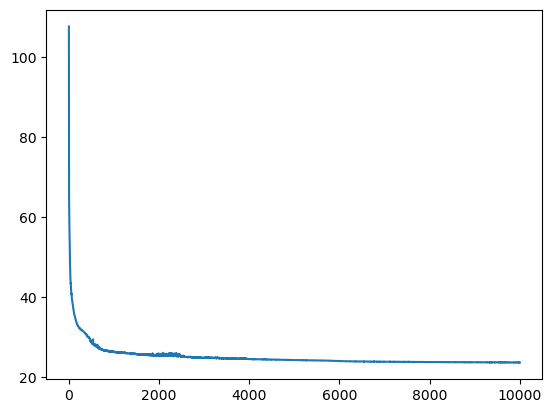

In [55]:
repbrep_path = '../../'
model_checkpoint_path = '../../training_logs/reconstruction/old_no_loops/version_0/checkpoints/epoch=38-val_loss=0.002679.ckpt'

cube_path = os.path.join(repbrep_path, 'datasets', 'cubes', 'cube.x_t')
angled_cube_path = os.path.join(repbrep_path, 'datasets', 'cubes', 'angled_cube.x_t')
long_cube_path = os.path.join(repbrep_path, 'datasets', 'cubes', 'long_cube.x_t')

frame_guide_1_path = os.path.join(repbrep_path, 'datasets', 'frame_guide', 'fg1.x_t')
frame_guide_2_path = os.path.join(repbrep_path, 'datasets', 'frame_guide', 'fg2.x_t')

rounded_rect_1_path = os.path.join(repbrep_path, 'datasets', 'rounded_rect', 'rounded_rect1.step')
rounded_rect_2_path = os.path.join(repbrep_path, 'datasets', 'rounded_rect', 'rounded_rect2.step')

holybox1_path = os.path.join(repbrep_path, 'datasets', 'holybox', 'holey_box.step')
holybox2_path = os.path.join(repbrep_path, 'datasets', 'holybox', 'holey_box_angled.step')

source_part_path = holybox1_path
target_part_path = holybox2_path

weighted = True
num_iters = 10000
reproject = False

sampler = SamplePoints(6*1000)

source_part = HPart(source_part_path, normalize=True).data
target_part = HPart(target_part_path, normalize=False).data
target_part_normalized = HPart(target_part_path, normalize=True).data

target_V = source_part.scale*(target_part.V + source_part.translation)
target_F = target_part.F
target_data = TGData(pos=target_V,face=target_F)
sampler(target_data)
target_pc = target_data.pos

checkpoint = torch.load(model_checkpoint_path)

model = BRepFaceAutoencoder(64, 1024,4, False)
model.load_state_dict(checkpoint['state_dict'])

n_faces = len(source_part.faces)
N = 50
line = torch.linspace(-0.1,1.1,N)
grid = torch.cartesian_prod(line, line)
grids = grid.repeat(n_faces,1)
indices = torch.arange(n_faces).repeat_interleave(N*N, dim=0)

model = model.cuda()
grids = grids.cuda()
indices = indices.cuda()
target = target_pc.unsqueeze(0).float().cuda()
source_part = source_part.cuda()

source_part.faces.requires_grad = True
source_part.edges.requires_grad = True
source_part.vertices.requires_grad = True

opt = torch.optim.SGD(
    [
        source_part.faces,
        source_part.edges,
        source_part.vertices
    ], 
    lr=0.00075, 
    momentum=0.3
)

losses = []
predictions = []
chamferDist = WeightedChamferDistance(sharpness=2) if weighted else ChamferDistance()


for iter in tqdm(range(num_iters)):
    opt.zero_grad()
    pred = model(source_part, grids, indices)
    pred_xyz = pred[:,:3].unsqueeze(0).float()
    pred_m = pred[:,3].unsqueeze(0).float()
    loss = chamferDist(pred.unsqueeze(0).float(), target) if weighted else chamferDist(pred_xyz, target) + chamferDist(target, pred_xyz)
    loss.backward()
    opt.step()
    losses.append(loss.detach().item())
    predictions.append((pred_xyz.detach().cpu().numpy(), pred_m.detach().cpu().numpy()))

plt.plot(losses)

In [56]:
n_plots = 10
n_preds = len(predictions)
plot_steps = torch.linspace(0,n_preds-1,n_plots).int().numpy()

for i in plot_steps:
    xyz = predictions[i][0][0,:,:]
    mask = predictions[i][1][0,:]

    plot = mp.plot(xyz, c=(mask <= 0.0), shading={'point_size':0.1}, return_plot=True)
    plot.add_points(target_pc.numpy(), shading={'point_size':0.1, 'point_color':'red'})


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0035903…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.151517…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.160740…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.165955…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.163906…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.155160…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.154115…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.154749…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.155642…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.158208…

In [61]:
source_part.faces[:,:5].argmax(dim=1)

tensor([1, 0, 0, 2, 0, 0, 0], device='cuda:0')

In [62]:
source_part.faces.shape

torch.Size([7, 21])

In [65]:
type = source_part.faces[:,:5].argmax(dim=1).detach().cpu().numpy()
origin = source_part.faces[:,5:8].cpu().detach().numpy()
normal = source_part.faces[:,8:11].cpu().detach().numpy()
axis = source_part.faces[:,11:14].cpu().detach().numpy()
ref_dif = source_part.faces[:,14:17].cpu().detach().numpy()
radius = source_part.faces[:,17].cpu().detach().numpy()
minor_radius = source_part.faces[:,18].cpu().detach().numpy()
semi_angle = source_part.faces[:,19].cpu().detach().numpy()
flipped = source_part.faces[:,20].cpu().detach().numpy()

In [ ]:
for i in range(len(type)):
    